In [2]:
import numpy as np

In [2]:
np.diag(np.arange(1))

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [6]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
np.ones(10) + 0.5

array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])

In [9]:
np.linalg.inv(np.diag(np.ones(5) + 0.5))

array([[ 0.66666667,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.66666667,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.66666667,  0.        ,  0.        ],
       [-0.        , -0.        , -0.        ,  0.66666667, -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.66666667]])

In [7]:
x = np.array([[10,2],[3,4]])

In [4]:
mask = np.random.choice([0,1], size=x.shape, p=[0.75, 0.25])

In [5]:
mask

array([[1, 0],
       [0, 0]])

In [8]:
np.multiply(mask, x)

array([[10,  0],
       [ 0,  0]])

# 1. Operators

In [67]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.projectB as im
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
x0 = plt.imread('assets/starfish.png')
i = im.Identity(x0.shape)
v = im.kernel('motion')
c = im.Convolution(x0.shape, v)
r = im.RandomMasking(x0.shape, 0.4)

<IPython.core.display.Javascript object>


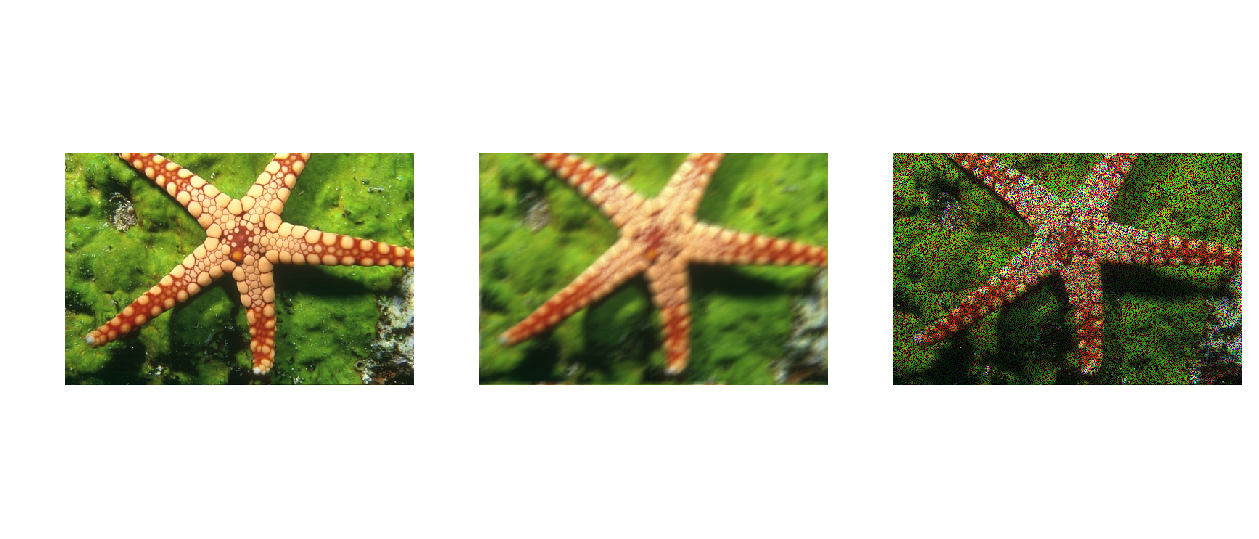

In [42]:
xI = i(x0)
xC = c(x0)
xR = r(x0)

fig, axes = plt.subplots(ncols=3, figsize=(7,3))
im.show(xI, ax=axes[0])
im.show(xC, ax=axes[1])
im.show(xR, ax=axes[2])
fig.show()

In [3]:
y = plt.imread('assets/flowers.png')

In [4]:
g = im.Grad(y.shape)

ValueError: setting an array element with a sequence.

# 2. Smoothed Total-Variation

### 7. Why does TV promote piece-wise constant solutions?

TV promotes piece-wise constant solutions due to the nature that TV smooths out large ‘flat’ regions in the image by only storing the gradient of the image to do so.   This is since the loss function, which is the gradient of x, is simply comparing the difference between a pixel and its neighbors, thus only detecting edges in the image.  Since there are relatively few edges in relation to image size, this leads TV to produce piece-wise constant solutions.  


### 8. Proving the gradient of the energy function

1.  Given: E(x) = 1/2 * l2_norm(y-Hx)^2 + tau * l1_norm(grad(x))
2.  Substitute grad(x) with the approximation sqrt(abs(grad(x))^2 + e)
3.  Differentiate both terms of the sum.
4.  d/dx (1/2 * l2_norm(y-Hx)^2) = -H* * (y-Hx) = H*(Hx-y)
5.  d/dx (tau * l1_norm(sqrt(abs(grad(x))^2 + e)))) = tau * grad(sqrt(abs(grad(x))^2 + e))
6.  Chain Rule: tau * grad(sqrt(abs(grad(x))^2 + e)) = tau * grad(grad(x) / sqrt(abs(grad(x))^2 + e)
7.  Def. of Divergence  tau * grad(grad(x) / sqrt(abs(grad(x))^2 + e) = -tau * div(grad(x) / sqrt(abs(grad(x))^2 + e)
8.  Combine both terms of sum to get grad(E(x)) as H*(Hx-y) - tau * div(grad(x) / sqrt(abs(grad(x))^2 + e)

In [88]:
x =  plt.imread('assets/starfish.png')
sig = 20 / 255
y = x + sig * np.random.randn(*x.shape)

### 9. Total Variation: Gradient Descent

In [ ]:
def total_variation(y,sig,H=None, m=400, scheme='gd', rho=1, return_energy=False):
    tau = rho * sig
    epsilon = sig**2 * 0.001
    if H is None:
        H = Identity(y.shape)
        
    laplacian = kernel('laplacian2')
    L = H.norm2()**2 + (tau/np.sqrt(epsilon)) * np.sqrt(np.sum(laplacian ** 2))
    gamma = 1 / L
    
    
    def energy(H, x, y, tau):
        op1 = 0.5 * np.sum((y-H(x))** 2)
        op2 = tau * np.sum(np.gradient(x))
        return op1 + op2
    
    def loss(H, x, y, tau, epsilon):
        op1 = H.gram(x) - H.adjoint(y)
        gradX = grad(x)
        op2 = tau * np.sum((gradX / np.sqrt(np.abs(gradX)**2 + epsilon)), axis=2)
        return op1 - op2
    
    x = H.adjoint(y)
    
    if scheme is 'gd':
        if return_energy:
            e = []        
            for i in range(m):
                e.append(energy(H,x,y,tau))
                x = x - gamma * loss(H,x,y,tau,epsilon)              
            return x, e

        else:
            for i in range(m):
                print("iteration %d"% i)
                x = x - gamma * loss(H,x,y,tau,epsilon)
            return x

### 10. Total Variation: Gradient Descent Using Nesterov Acceleration

In [ ]:
def total_variation(y,sig,H=None, m=400, scheme='gd', rho=1, return_energy=False):
    ...
    elif scheme is 'nesterov':        
        xBar = H.adjoint(y)
        prevX = x
        
        def calcT1(t):
            return (1 + np.sqrt(1 + 4*t**2)) / 2
        
        def calcU(t, t1):
            return (t-1)/t1
        
        t = 1
        t1 = calcT1(t)
        
        if return_energy:
            e = []
            for i in range(m):
                e.append(energy(H,x,y,tau))
                prevX = x
                x = xBar - gamma * loss(H,xBar,y,tau,epsilon)
                xBar = x + calcU(t,t1)*(x-prevX)          
                t = t1
                t1 = calcT1(t)
            return x, e
        
        else:
            for i in range(m):
                print("iteration %d"% i)
                prevX = x
                x = xBar - gamma * loss(H,xBar,y,tau,epsilon)
                xBar = x + calcU(t,t1)*(x-prevX)          
                t = t1
                t1 = calcT1(t)
            return x

In [99]:
#xHat, eGD = im.total_variation(y, sig, m=10, return_energy=True)
xHatNest, eNest = im.total_variation(y, sig, m=100, scheme='nesterov', return_energy=True)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42


In [102]:
plt.imshow(xHatNest)
#xCP, eCP = im.total_variation(y, sig, m=50, return_energy=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [104]:
eNest

[7209.424335104508,
 7136.767210758613,
 7065.581228673374,
 6976.427566232946,
 6871.244348508621,
 6751.941708720619,
 6620.513749285272,
 6478.886004229495,
 6329.068721514174,
 6173.0949431211775,
 6013.007350177855,
 5850.815347364198,
 5688.303493609167,
 5527.2181484115035,
 5369.113653179307,
 5215.381749239464,
 5067.280148636683,
 4925.653548334672,
 4791.217160904583,
 4664.644031570146,
 4546.132834878522,
 4435.691327481931,
 4333.6473797264125,
 4239.916214655754,
 4154.299450185412,
 4076.4085390151167,
 4005.8717221290253,
 3942.406767098787,
 3885.385896860231,
 3834.758454270434,
 3790.070235261814,
 3750.922526780345,
 3717.10826815198,
 3688.4807996838445,
 3664.57124236407,
 3644.9179399792565,
 3629.198793519642,
 3617.0805597302524,
 3608.3630574258377,
 3602.5979115585733,
 3599.5107946412386,
 3598.9333513837505,
 3600.4922518632393]

C:\Users\Luke\Desktop\Anaconda\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


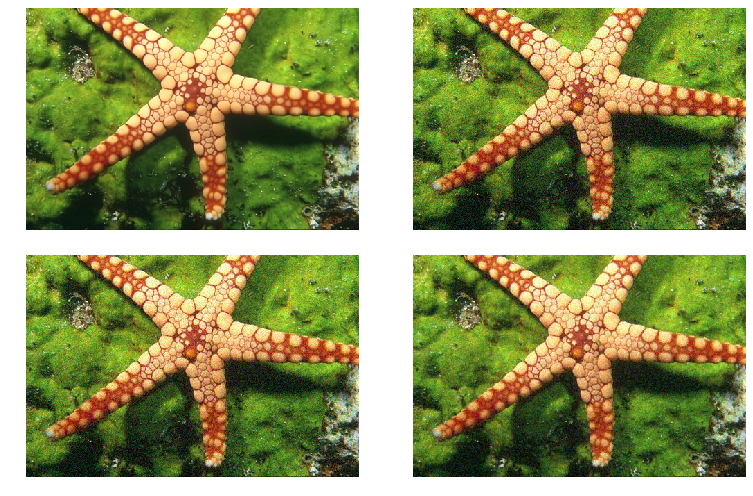

In [13]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(12,7))
im.show(x, ax[0][0])
im.show(y, ax[0][1])
im.show(xHat, ax[1][0])
im.show(xCP, ax[1][1])
fig.show()

# 3. Advanced Solvers for Total-Variation

### 14. SoftThresh

In [33]:
def softthresh(z, t):
    z[np.abs(z) <= t] = 0
    return z - np.sign(z)*t

In [34]:
x = np.array([-20,-10,-5,0,5,10,20])
softthresh(x, 5)

array([-15,  -5,   0,   0,   0,   5,  15])

In [68]:
x = plt.imread('assets/starfish.png')
sig = 20 / 255
y = x + sig * np.random.randn(*x.shape)

In [69]:
xHatCP, e = im.total_variation(y, sig, m=10, scheme='cp', return_energy=True)

Energy: 7235.431481
iteration 0
Energy: 7235.431481
iteration 1
Energy: 7233.611271
iteration 2
Energy: 7233.051835
iteration 3
Energy: 7232.871365
iteration 4
Energy: 7232.805126
iteration 5
Energy: 7232.777958
iteration 6
Energy: 7232.765746
iteration 7
Energy: 7232.759928
iteration 8
Energy: 7232.757093
iteration 9


In [81]:
rho = 1
tau = rho * sig
H = im.Identity(y.shape)
m = 10

def energy(H, x, y, tau):
    G = im.Grad(x.shape)
    op1 = 0.5 * np.sum(np.square(y-H(x)))
    op2 = tau * np.sum(np.abs(G(x)))
    print('Energy: %f' % (op1+op2))
    return op1 + op2

def softthresh(z, t):
    z[np.abs(z) <= t] = 0
    return z - np.sign(z)*t

#init
G = im.Grad(y.shape)
gamma = 1
theta = 1
k = 1/(G.norm2()**2)
x = H.adjoint(y)
z = np.zeros(G(x).shape)
v = np.zeros(x.shape)
e = []

for i in range(m):
    e.append(energy(H,x,y,tau))
    print('iteration %d' % i)
    zBar = z + k * G(v)
    z = zBar - softthresh(zBar, tau)
    xBar = x - gamma*G.adjoint(z)
    prevX = np.copy(x)
    x1 = H.gram_resolvent((xBar + (gamma*H.adjoint(y))), gamma)
    v = x1 + x1 - x
    x = x1

Energy: 7235.431481
iteration 0
Energy: 7235.431481
iteration 1
Energy: 7233.611271
iteration 2
Energy: 7233.051835
iteration 3
Energy: 7232.871365
iteration 4
Energy: 7232.805126
iteration 5
Energy: 7232.777958
iteration 6
Energy: 7232.765746
iteration 7
Energy: 7232.759928
iteration 8
Energy: 7232.757093
iteration 9


In [ ]:
e.append(energy(H,x,y,tau))
print('iteration %d' % i)
zBar = z + k * G(v)
z = zBar - softthresh(zBar, tau)
xBar = x - gamma*G.adjoint(z)
prevX = np.copy(x)
x = H.gram_resolvent((xBar + (gamma*H.adjoint(y))), gamma)
v = x + x - prevX

<IPython.core.display.Javascript object>


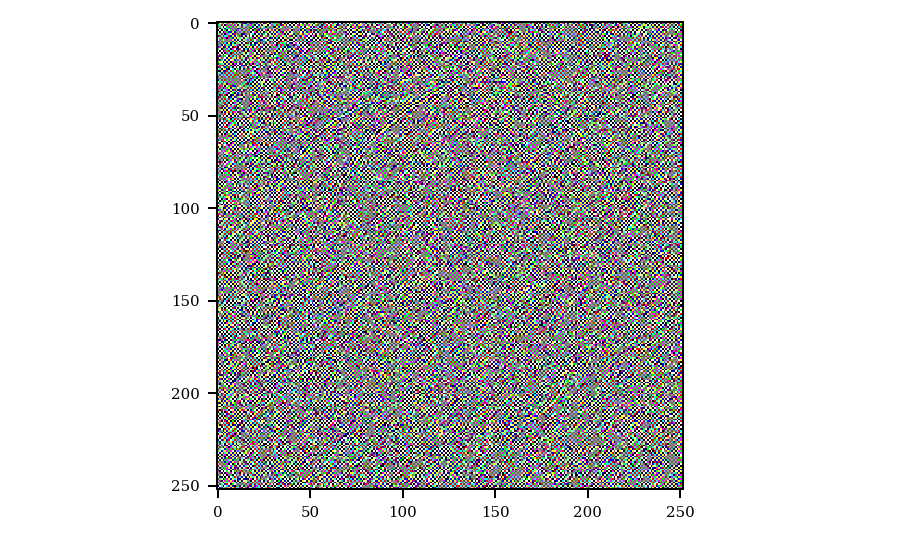

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [80]:
a = H.gram_resolvent(xBar, 1)
b = H.gram_resolvent(gamma*H.adjoint(y), gamma)
plt.imshow(a+b)

In [63]:
G = im.Grad(y.shape)
z = G(y)
z.shape
zStar = G.adjoint(z)
zStar.shape

(321, 481, 3)

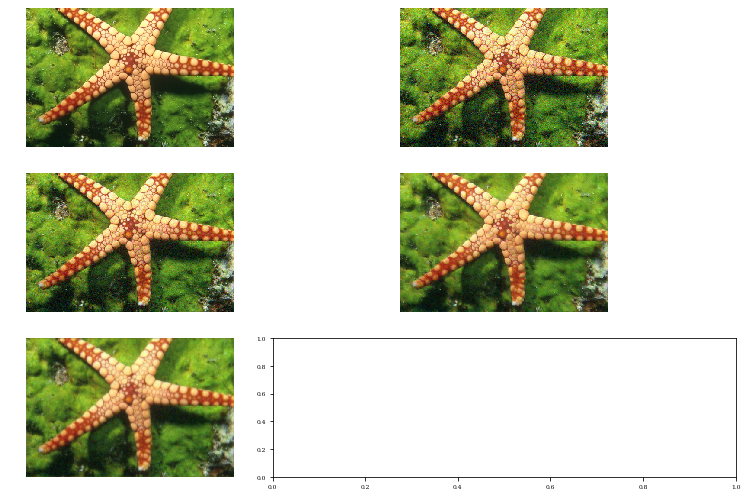

In [75]:
fig,ax = plt.subplots(nrows=3, ncols=2, figsize=(12,7))
im.show(x, ax[0][0])
im.show(y, ax[0][1])
im.show(xHat, ax[1][0])
im.show(xHatNest, ax[1][1])
im.show(xHatADMM, ax[2][0])
fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7218.044148808449,
 7218.044148808449,
 7216.343116479353,
 7215.818493097722,
 7215.642417769137,
 7215.577320861347,
 7215.549484856235,
 7215.536808207568,
 7215.530782761652,
 7215.527985099595]

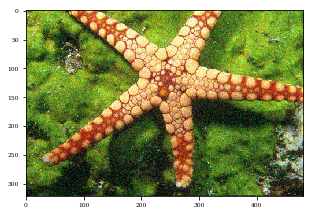

In [56]:
plt.imshow(xHatCP)
e

# 4. Total Generalized Variation

### 19 TGV = TV when C = 0

When C = 0 the term tau * min_z(norm_1(grad(x) - C*z) + norm_1(div(z)) becomes tau*norm_1(grad(x)) which is the same as total variation.  When C = 0, the z term inside the norm_1 of x is zero'd out, leaving the original term of norm_1(x), however that still leaves the additional norm_1(div(z)) to be dealt with.  However, since the entire expression is inside a minimum with respect to z, the minimum z will be found that sets the norm_1(div(z)) to be 0, which is just the 0 vector for z.  Since both z terms get cancelled out when C=0, TGV is equivalent to TV when C=0 since the rest of the expression is the same

### 20. TGV promoting piece-wise affine solutions

To understand why TGV promotes piece-wise affine solutions, it is helpful to understand why TV does not promote affine solutions.  TV does not promote affine solutions since it is assuming that the gradient of x can only be taken in 2 directions (right and down, due to the definition of the grad kernel), this produces square artifacts in the TV reconstruction since by nature of the algorithm it is assuming that images consist of similar colorred square patches.  However, in TGV we discard this assumption with the addition of the z vector.  The z vector now allows us to take the gradient in any direction, and, since it is minimized in the TGV expression, it chooses the direction z that minimizes the loss.  By doing this, we would assume that the resulting images will no longer have square artifacts in the result since the directions of TGV are not limited to the x,y axes.

### 21 TGV Rewritten Proof

This one is pretty simple, just take the given formula, substitute the matrices, and perform matrix multiplication to get the original TV formula.  There is one step in the second term of the sum where you make use that norm_1 is a linear operator (since it is a sum) so you can separate out the div(z).  Otherwise, the min_z from the original expression is lost, but that is ok since you are using a given z in the form of X = (x,z)

In [5]:
G = im.Grad(y.shape)
G(x).shape

(321, 481, 2, 3)

In [13]:
x0 = plt.imread('assets/ball.png')
sig = 10 / 255
y = x + sig * np.random.randn(*x.shape)
starfish = plt.imread('assets/starfish.png')
flowers = plt.imread('assets/flowers.png')
#xHatTGV = im.tgv(y, sig, m=50)

In [64]:
starfish = plt.imread('assets/starfish.png')
flowers = plt.imread('assets/flowers.png')
x = starfish
y = flowers
zeta = 0.1

GaX = im.Gamma(x.shape, zeta)
GaY = im.Gamma(y.shape, zeta)
zY = np.zeros(im.Grad(y.shape)(y).shape)
z = np.zeros(im.Grad(x.shape)(x).shape)
x_ic = GaX([x,z])
y_ia = GaY.adjoint([zY,y])
print("The statement for Gamma operator:",np.isclose(np.sum(x_ic*y),np.sum(x*y_ia)))

ValueError: could not broadcast input array from shape (321,481,2,3) into shape (321,481)

In [29]:
print(x_ic[0].shape)
print(x_ic[1].shape)
print(y_ia[0].shape)
print(y_ia[1].shape)

(321, 481, 2, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 2, 3)


In [32]:
gramX = GaX.gram([x,z])

In [34]:
print(gramX[0].shape)
print(gramX[1].shape)

(321, 481, 3)
(321, 481, 2, 3)


In [70]:
X = [x,z]
t = 0.5
intermediate = GaX.gram(X)
l = [intermediate[0] * t, intermediate[1] * t]
x_rl = GaX.gram_resolvent(X+l, t)
print("The statement for Gamma operator:",np.allclose(x_rl[0], X[0]))
print("The statement for Gamma operator:",np.allclose(x_rl[1], X[1]))

H = im.HBar(im.Identity(X[0].shape))
intermediate = H.gram(X)
l = [intermediate[0] * t, intermediate[1] * t]
x_hb = H.gram_resolvent(X+l, t)

print("The statement for Hbar operator:",np.allclose(x_hb[0], X[0]))

The statement for Gamma operator: True
The statement for Gamma operator: True
The statement for Hbar operator: False


In [74]:
x_hb[0].shape
x_hb[1].shape

(321, 481, 2, 3)

In [42]:
x_rl[1].shape

(321, 481, 2, 3)

In [52]:
l

[array([[[0.12745102, 0.14117651, 0.07647059],
         [0.12156868, 0.13725493, 0.06078434],
         [0.14117655, 0.15294122, 0.05882354],
         ...,
         [0.19019607, 0.29215694, 0.07647062],
         [0.19411772, 0.30000005, 0.08039219],
         [0.16666665, 0.27647065, 0.06274512]],
 
        [[0.19999996, 0.22745097, 0.12352943],
         [0.17843142, 0.20588236, 0.09019609],
         [0.15686279, 0.18039225, 0.05098041],
         ...,
         [0.1862745 , 0.2882353 , 0.0764706 ],
         [0.19215682, 0.29803924, 0.08039215],
         [0.17254911, 0.2823529 , 0.06862747]],
 
        [[0.24117649, 0.30000006, 0.11176469],
         [0.34705884, 0.40196081, 0.20588236],
         [0.33333339, 0.37647065, 0.17843139],
         ...,
         [0.17843134, 0.28235294, 0.07843135],
         [0.17647059, 0.28627451, 0.07647055],
         [0.17058826, 0.28235291, 0.072549  ]],
 
        ...,
 
        [[0.01764702, 0.05294122, 0.02941178],
         [0.01764702, 0.05294123, 0.02941

In [83]:
x0 = plt.imread('assets/ball.png')
sig = 10/255
v = im.kernel('motion')
c = im.Convolution(x0.shape, v)
y = c(x0)

y = x0 + sig * np.random.randn(*x0.shape)
plt.imshow(y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [87]:
XTGV, eTGV = im.tgv(y, sig, zeta=.1, m=10, return_energy=True)

iteration 0
Energy: 341118.713778
iteration 1
Energy: 3096341.014965
iteration 2
Energy: 18008212.560401
iteration 3
Energy: 110308244.704999
iteration 4
Energy: 1277328779.589380
iteration 5
Energy: 31523590914.692505
iteration 6
Energy: 1042852222665.203613
iteration 7
Energy: 37533530314647.804688
iteration 8
Energy: 1403145042074517.750000
iteration 9
Energy: 53750191727138544.000000


In [88]:
plt.imshow(XTGV[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


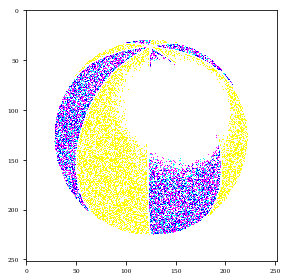

In [18]:
plt.imshow(XTGV[0])

In [58]:
gX[0].shape

(321, 481, 3)

In [59]:
gX[1].shape

(321, 481, 2, 3)

In [87]:
def energy(H, x, y, tau):
    Gr = im.Grad(x.shape)
    op1 = 0.5 * np.sum(np.square(y-H(x)))
    op2 = tau * np.sum(np.abs(Gr(x)))
    return op1 + op2

def softthresh(z, t):
    z[np.abs(z) <= t] = 0
    return z - np.sign(z)*t

y = y
sig = sig
zeta = .1
m = 50
return_energy = True
rho = 1
H = None

tau = rho * sig
if H is None:
    H = im.Identity(y.shape)  
x = H.adjoint(y)

H = im.HBar(H)

G = im.Gamma(y.shape, zeta)
gamma = 1
theta = 1
print(G.norm_2())
k = [1 / (G.norm_2()[0]**2), 1 / (G.norm_2()[1]**2)]
v = np.zeros(x.shape)

# update param's img -> (img, vec) vec -> (vec, img)
X = [x, np.zeros(im.Grad(x.shape)(x).shape)]  
V = [v, np.zeros(im.Grad(x.shape)(x).shape)]
Z = [np.zeros(im.Grad(x.shape)(x).shape), np.zeros(x.shape)]
zeroField = np.zeros(im.Grad(x.shape)(x).shape)

ZBar = None
XBar = None
PrevX = None

if return_energy:
    e = []
    for i in range(m):
        print('iteration %d' %i)
        e.append(energy(H,X[0],y,tau))
        ZBar = [Z[0] + k[0]*G(V)[0], Z[1] + k[1]*G(V)[1]]
        Z = [ZBar[0] - softthresh(ZBar[0], tau), ZBar[1] - softthresh(ZBar[1], tau)]
        XBar = [X[0] - gamma * G.adjoint(Z)[0], X[1] - gamma * G.adjoint(Z)[1]]
        PrevX = [np.copy(X[0]), np.copy(X[1])]
        X = [H.gram_resolvent(XBar, gamma)[0] + H.gram_resolvent(gamma*H.adjoint([y,zeroField])), gamma)[0], H.gram_resolvent(XBar, gamma)[1]]+ H.gram_resolvent(gamma*H.adjoint([y,zeroField]), gamma)[1]]
        V = [X[0] + theta*(X[0] - PrevX[0]), X[1] + theta*(X[1] - PrevX[1])]


SyntaxError: invalid syntax (<ipython-input-87-ff9bc7d7b012>, line 52)

array([[[3.97353915e+13, 6.18142791e+13, 4.41528622e+13],
        [3.97357826e+13, 6.18144820e+13, 4.41524970e+13],
        [3.97379841e+13, 6.18151676e+13, 4.41516299e+13],
        ...,
        [3.60950415e+14, 3.96272663e+14, 2.24076178e+14],
        [3.09691607e+14, 3.58259669e+14, 1.81647964e+14],
        [2.48360406e+14, 2.96928537e+14, 1.11486186e+14]],

       [[3.97275446e+13, 6.18145406e+13, 4.41530880e+13],
        [3.97295779e+13, 6.18148525e+13, 4.41525867e+13],
        [3.97376884e+13, 6.18155298e+13, 4.41488921e+13],
        ...,
        [3.58742666e+14, 3.94065079e+14, 2.21868549e+14],
        [3.10174446e+14, 3.58742743e+14, 1.82130894e+14],
        [2.54431349e+14, 3.02999618e+14, 1.17557200e+14]],

       [[3.96971962e+13, 6.18151796e+13, 4.41539171e+13],
        [3.97052729e+13, 6.18155069e+13, 4.41529392e+13],
        [3.97362639e+13, 6.18155073e+13, 4.41488949e+13],
        ...,
        [3.60674297e+14, 3.96686546e+14, 2.23800208e+14],
        [3.17211241e+14, 3.65

In [54]:
print(Z[0].shape)
print(Z[1].shape)
print(G(V)[0].shape)
print(G(V)[1].shape)

(252, 252, 2, 3)
(252, 252, 3)
(252, 252, 2, 3)
(252, 252, 3)


In [77]:
print(X[0].shape)
print(PrevX[0].shape)
print(X[1].shape)
print(PrevX[1].shape)

(321, 481, 3)
(321, 481, 3)
(481, 3)
(321, 481, 2, 3)


In [82]:
H.gram_resolvent(XBar, gamma)[0].shape

(321, 481, 3)